# 1. Scrapping

In [98]:
from bs4 import BeautifulSoup
from pathlib import Path
import requests

def get_text_auto(file_or_url):
  # Cek apakah input merupakan sebuah file
  if Path(file_or_url).is_file(): is_file = True
  else: is_file = False

  # Bila berupa file
  if is_file:
    # Cek tipe/ekstensi file
    file_ext = Path(file_or_url).suffix

    # Bila tipe file didukung
    if file_ext in ('.txt', '.html'):
      # Baca isi dari file sebagai plain teks
      file = open(file_or_url, 'r')
      text_content = file.read()
      file.close()

      # Parse HTML dahulu bila bukan plain teks
      if file_ext == '.html':
        text_content = get_text_from_url(text_content, True)
    # Bila tipe file tidak didukung
    else:
      print('Format file tidak didukung!')
      text_content = '""'
  # Bila berupa URL
  else:
    text_content = get_text_from_url(file_or_url)

  # Berikan isi teks dari file atau URL
  return text_content

def get_text_from_url(url_content, from_file = False):
  if not from_file:
    # Dapatkan konten HTML dari URL
    url_content = requests.get(url_content, headers = {
      'User-Agent': 'Mozilla/5.0 (Linux; Android 13) Chrome/107.0',
      'Save-Data': 'on'
    }).content
  else:
    # Data sudah dalam bentuk HTML
    pass

  # Objek bantuan untuk fungsi filter tag HTML dll
  soup = BeautifulSoup(url_content, 'html.parser')
  # Isi teks mula-mula (kosong)
  text_content = ''
  # Teks sampah pada beberapa situs (detik.com, dll)
  # TODO: Gunakan filter adblock sebagai alternatif
  text_noise = (
    'ADVERTISEMENT',
    'SCROLL TO RESUME CONTENT',
    'SCROLL TO CONTINUE WITH CONTENT'
  )

  # Ambil semua paragraf dari HTML
  for paragraph in soup.find_all('p'):
    # Hapus superscript (referensi Wikipedia) dari teks
    for p in paragraph.select('sup'): p.extract()
    # Hapus promosi video dan penulis dari detik.com
    for p in paragraph.select('strong'):
      temp_text = p.get_text().lower().strip()
      if temp_text.startswith(
        ('lihat', 'simak', 'baca', 'tonton', '(', '[')
      ): p.extract()
    # Hapus whitespace sesudah dan sebelum teks
    temp_text = paragraph.get_text().strip()
    # Filter kata sampah (bukan stop word)
    if temp_text not in text_noise:
      text_content += temp_text + ' '
  
  # Berikan isi teks
  return text_content

In [99]:
doc = get_text_auto('https://travel.detik.com/travel-news/d-6390734/pilot-mogok-kerja-ribuan-penumpang-gagal-terbang')
# doc = get_text_auto('https://finance.detik.com/infografis/d-6412382/buruh-tolak-ump-2023-mengacu-pp-362021-ancam-aksi-besar-besaran')
# doc = get_text_auto('https://news.detik.com/berita/d-6411924/2-perusahaan-tersangka-kasus-gagal-ginjal-akut-terancam-15-dan-10-tahun-bui')
# doc = get_text_auto('https://inet.detik.com/science/d-6412223/meteorit-langka-yang-jatuh-tahun-lalu-ungkap-asal-air-di-bumi')
# doc = get_text_auto('https://www.detik.com/bali/berita/d-6412272/sandiaga-desak-hari-ekonomi-kreatif-nasional-segera-disahkan')

print(doc)

Ribuan penumpang pesawat gagal terbang akibat pemogokan oleh Asosiasi Pilot Maskapai Kenya (KALPA). Aksi pilot mogok itu sudah berlangsung dua hari. KALPA memastikan tidak ada penerbangan Kenya Airways yang diterbangkan oleh anggotanya dari Bandara Internasional Jomo Kenyatta Nairobi mulai pukul 06.00 pagi (0300 GMT) dan seterusnya. Pernyataan itu disampaikan pada Sabtu (5/11/2022) waktu setempat. Mereka tidak memberikan keterangan berapa lama mogok kerja itu berlangsung. Maskapai, yang dibangun bersama oleh pemerintah Kenya dan Air France-KLM itu, merupakan salah satu maskapai terbesar di Afrika. Kenya Airways menghubungkan banyak negara ke Eropa dan Asia, sehingga aksi mogok pilot itu benar-benar melumpuhkan denyut penerbangan di negara tersebut. KALPA menyebut akan melakukan aksi mogok kerja menyusul sengketa kontribusi uang pensiun dan penyelesaian pembayaran gaji saat pandemi. Aksi mogok kerja itu dilakukan setelah tuntutan disampaikan 14 hari lalu tetapi manajemen Kenya Airways t

# 2. Text Preprocessing

## 2.2. Sentence Tokenization

In [100]:
from spacy.lang.id import Indonesian
from spacy.symbols import ORTH

def sentence_tokenization(text):
  nlp = Indonesian()
  nlp.add_pipe('sentencizer')

  # Jangan anggap kasus berikut sebagai akhir kalimat
  nlp.tokenizer.add_special_case("Ir.", [{ORTH: "Ir."}])
  nlp.tokenizer.add_special_case("Mr.", [{ORTH: "Mr."}])
  nlp.tokenizer.add_special_case("PT.", [{ORTH: "PT."}])

  # Muat teks ke dalam pipeline
  doc = nlp(text)

  # Simpan hasil tokenisasi kalimat ke dalam list kalimat
  sentence_list = [ str(sentence) for sentence in doc.sents ]

  # Workaround kesalahan pengutipan pada tokenizer Indonesia
  for i, sentence in enumerate(sentence_list):
    # Kalimat diakhiri dengan titik dan kutip
    if sentence.endswith('. "'):
      sentence_list[i] = sentence_list[i][:-2]
      sentence_list[i+1] = '"' + sentence_list[i+1]
    # Kalimat diakhiri dengan titik, kutip, dan kurung
    elif sentence.endswith('. "('):
      sentence_list[i] = sentence_list[i][:-3]
      sentence_list[i+1] = '"(' + sentence_list[i+1]
  
  return sentence_list

In [101]:
sentence_list = sentence_tokenization(doc)

for i, sentence in enumerate(sentence_list):
    print(f'[{i+1}] {sentence}')

[1] Ribuan penumpang pesawat gagal terbang akibat pemogokan oleh Asosiasi Pilot Maskapai Kenya (KALPA).
[2] Aksi pilot mogok itu sudah berlangsung dua hari.
[3] KALPA memastikan tidak ada penerbangan Kenya Airways yang diterbangkan oleh anggotanya dari Bandara Internasional Jomo Kenyatta Nairobi mulai pukul 06.00 pagi (0300 GMT) dan seterusnya.
[4] Pernyataan itu disampaikan pada Sabtu (5/11/2022) waktu setempat.
[5] Mereka tidak memberikan keterangan berapa lama mogok kerja itu berlangsung.
[6] Maskapai, yang dibangun bersama oleh pemerintah Kenya dan Air France-KLM itu, merupakan salah satu maskapai terbesar di Afrika.
[7] Kenya Airways menghubungkan banyak negara ke Eropa dan Asia, sehingga aksi mogok pilot itu benar-benar melumpuhkan denyut penerbangan di negara tersebut.
[8] KALPA menyebut akan melakukan aksi mogok kerja menyusul sengketa kontribusi uang pensiun dan penyelesaian pembayaran gaji saat pandemi.
[9] Aksi mogok kerja itu dilakukan setelah tuntutan disampaikan 14 hari l

### 2.2.1. Regex Cleaning

In [102]:
import re
import unicodedata

def sentence_clean_regex(sentence_list):
  for i, sentence in enumerate(sentence_list):
    # Hilangkan semua karakter non-ASCII (UNICODE, dll)
    # sentence = re.sub(r'[^\x00-\x7f]','', sentence)
    # sentence = sentence.encode('ascii', 'ignore').decode()
    sentence = unicodedata.normalize('NFKC', sentence)

    # Hilangkan URL
    sentence = re.sub(r'http[s]?://\S+', '', sentence)
    # Hilangkan tag/mention
    sentence = re.sub(r'@\S+', '', sentence)
    # Hilangkan hashtag
    sentence = re.sub(r'#\S+', '', sentence)

    # Hilangkan semua kata yang hanya terdiri dari non-alphabet
    # https://stackoverflow.com/questions/72318334
    sentence = re.sub(r'(?<!\S)[^A-Za-z]+(?!\S)', '', sentence)

    # Hilangkan semua karakter spesial yang tidak berada di antara alphanumerik
    # https://stackoverflow.com/questions/61049643
    sentence = re.sub(r'(?<!\w)\W+|\W+(?!\w)', ' ', sentence)

    # Hilangkan whitespace beruntun (lebih dari satu)
    sentence = re.sub(r'\s\s+', ' ', sentence)

    # Ganti isi kalimat saat ini dengan isi variabel sementara
    sentence_list[i] = sentence

  return sentence_list

In [103]:
from copy import deepcopy

# Salin list kalimat ke dalam variabel baru
sentence_list_regex = deepcopy(sentence_list)

# Hilangkan kata yang sesuai filter regex dari list kalimat
sentence_list_regex = sentence_clean_regex(sentence_list_regex)
for i, sentence in enumerate(sentence_list_regex):
    print(f'[{i+1}] {sentence}')

[1] Ribuan penumpang pesawat gagal terbang akibat pemogokan oleh Asosiasi Pilot Maskapai Kenya KALPA 
[2] Aksi pilot mogok itu sudah berlangsung dua hari 
[3] KALPA memastikan tidak ada penerbangan Kenya Airways yang diterbangkan oleh anggotanya dari Bandara Internasional Jomo Kenyatta Nairobi mulai pukul pagi GMT dan seterusnya 
[4] Pernyataan itu disampaikan pada Sabtu waktu setempat 
[5] Mereka tidak memberikan keterangan berapa lama mogok kerja itu berlangsung 
[6] Maskapai yang dibangun bersama oleh pemerintah Kenya dan Air France-KLM itu merupakan salah satu maskapai terbesar di Afrika 
[7] Kenya Airways menghubungkan banyak negara ke Eropa dan Asia sehingga aksi mogok pilot itu benar-benar melumpuhkan denyut penerbangan di negara tersebut 
[8] KALPA menyebut akan melakukan aksi mogok kerja menyusul sengketa kontribusi uang pensiun dan penyelesaian pembayaran gaji saat pandemi 
[9] Aksi mogok kerja itu dilakukan setelah tuntutan disampaikan hari lalu tetapi manajemen Kenya Airway

### 2.2.2. Stopwords Removal

In [104]:
# Cek daftar kata dalam stopwords bawaan
# from spacy.lang.id.stop_words import STOP_WORDS

def sentence_stopwords_removal(sentence_list):
  nlp = Indonesian()
  # Tambah stopwords baru (bila ada)
  # nlp.Defaults.stop_words.add("kata_sampah")

  for i, sentence in enumerate(sentence_list):
    # Tokenisasi kalimat (menjadi per kata)
    tokens = nlp.tokenizer(sentence)
    # Kosongkan kalimat saat ini
    sentence_list[i] = ''
    # Tambah token ke kalimat bila bukan stopword
    # Sertakan juga pemisah antar kata (spasi)
    for token in tokens:
      if not token.is_stop:
        sentence_list[i] += token.text + token.whitespace_

  return sentence_list

In [105]:
from copy import deepcopy

# Salin list kalimat ke dalam variabel baru
sentence_list_nosw = deepcopy(sentence_list_regex)

# Hilangkan stopwords dari list kalimat
sentence_list_nosw = sentence_stopwords_removal(sentence_list_nosw)
for i, sentence in enumerate(sentence_list_nosw):
    print(f'[{i+1}] {sentence}')

[1] Ribuan penumpang pesawat gagal terbang akibat pemogokan Asosiasi Pilot Maskapai Kenya KALPA 
[2] Aksi pilot mogok 
[3] KALPA penerbangan Kenya Airways diterbangkan anggotanya Bandara Internasional Jomo Kenyatta Nairobi pagi GMT 
[4] Pernyataan Sabtu 
[5] keterangan mogok kerja 
[6] Maskapai dibangun pemerintah Kenya Air France-KLM salah maskapai terbesar Afrika 
[7] Kenya Airways menghubungkan negara Eropa Asia aksi mogok pilot benar-benar melumpuhkan denyut penerbangan negara 
[8] KALPA menyebut aksi mogok kerja menyusul sengketa kontribusi uang pensiun penyelesaian pembayaran gaji pandemi 
[9] Aksi mogok kerja tuntutan manajemen Kenya Airways meresponsnya 
[10] Manajemen Kenya Airways menggambarkan aksi mogok kerja pilot melanggar hukum 
[11] Maskapai aksi membahayakan upaya pemulihan pandemi Covid-19 Kenya Airways mengalami kerugian Rp miliar 
[12] Direktur pelaksana CEO Kenya Airways Allan Kilavuka mendesak pilot mogok persen karyawan maskapai Minggu 
[13]  dilaksanakan pilot d

### 2.2.3. Word Lemmatization

In [106]:
def sentence_lemmatization(sentence_list):
  nlp = Indonesian()
  # Lemmatizer butuh install package "spacy_lookups_data"
  # https://github.com/explosion/spacy-lookups-data/tree/master/spacy_lookups_data/data
  lemmatizer = nlp.add_pipe("lemmatizer", config = {"mode": "lookup"})
  # Muat daftar kata dari "spacy_lookups_data"
  nlp.initialize()

  for i, sentence in enumerate(sentence_list):
    # Tokenisasi kalimat (menjadi per kata)
    tokens = lemmatizer(nlp.tokenizer(sentence))
    # Kosongkan kalimat saat ini
    sentence_list[i] = ''
    # Tambah token ke kalimat dalam bentuk lemma (bila ada)
    # Sertakan juga pemisah antar kata (spasi)
    for token in tokens:
      if token.lemma_:
        sentence_list[i] += token.lemma_ + token.whitespace_
      else:
        sentence_list[i] += token.text + token.whitespace_
    
  return sentence_list

In [107]:
# Salin list kalimat ke dalam variabel baru
sentence_list_lemma = deepcopy(sentence_list_nosw)

# Ubah kata menjadi kata dasar pada kumpulan kalimat
sentence_list_lemma = sentence_lemmatization(sentence_list_lemma)
for i, sentence in enumerate(sentence_list_lemma):
    print(f'[{i+1}] {sentence}')

[1] Ribuan tumpang pesawat gagal terbang akibat mogok Asosiasi Pilot Maskapai Kenya KALPA 
[2] Aksi pilot mogok 
[3] KALPA terbang Kenya Airways diterbangkan anggotanya Bandara Internasional Jomo Kenyatta Nairobi pagi GMT 
[4] Pernyataan Sabtu 
[5] terang mogok kerja 
[6] Maskapai dibangun perintah Kenya Air France-KLM salah maskapai besar Afrika 
[7] Kenya Airways hubung negara Eropa Asia aksi mogok pilot benar lumpuh denyut terbang negara 
[8] KALPA sebut aksi mogok kerja susul sengketa kontribusi uang pensiun selesai bayar gaji pandemi 
[9] Aksi mogok kerja tuntut manajemen Kenya Airways respons 
[10] Manajemen Kenya Airways gambar aksi mogok kerja pilot langgar hukum 
[11] Maskapai aksi bahaya upaya pulih pandemi Covid-19 Kenya Airways alam rugi Rp miliar 
[12] Direktur laksana CEO Kenya Airways Allan Kilavuka desak pilot mogok persen karyawan maskapai Minggu 
[13]  dilaksanakan pilot dianggap tindak indisipliner ingat 
[14] Aksi mogok pilot 
[15] Serikat Pekerja Penerbangan Kenya 

### 2.2.4. Word Stemming

In [108]:
# https://github.com/har07/PySastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def sentence_stemming(sentence_list):
  stemmer = StemmerFactory().create_stemmer()
  for i, sentence in enumerate(sentence_list):
    sentence_list[i] = stemmer.stem(sentence)
  
  return sentence_list

In [109]:
# Salin list kalimat ke dalam variabel baru
sentence_list_stem = deepcopy(sentence_list_lemma)

# Hilangkan imbuhan kata pada kumpulan kalimat
sentence_list_stem = sentence_stemming(sentence_list_stem)
for i, sentence in enumerate(sentence_list_stem):
    print(f'[{i+1}] {sentence}')

[1] ribu tumpang pesawat gagal terbang akibat mogok asosiasi pilot maskapai kenya kalpa
[2] aksi pilot mogok
[3] kalpa terbang kenya airways terbang anggota bandara internasional jomo kenyatta nairobi pagi gmt
[4] nyata sabtu
[5] terang mogok kerja
[6] maskapai bangun perintah kenya air france-klm salah maskapai besar afrika
[7] kenya airways hubung negara eropa asia aksi mogok pilot benar lumpuh denyut terbang negara
[8] kalpa sebut aksi mogok kerja susul sengketa kontribusi uang pensiun selesai bayar gaji pandemi
[9] aksi mogok kerja tuntut manajemen kenya airways respons
[10] manajemen kenya airways gambar aksi mogok kerja pilot langgar hukum
[11] maskapai aksi bahaya upaya pulih pandemi covid-19 kenya airways alam rugi rp miliar
[12] direktur laksana ceo kenya airways allan kilavuka desak pilot mogok persen karyawan maskapai minggu
[13] laksana pilot anggap tindak indisipliner ingat
[14] aksi mogok pilot
[15] serikat kerja terbang kenya kawu respons umum staf darat mogok sabtu
[16]

## 2.3. Word Tokenization
Word tokenization tidak dibutuhkan karena proses TF-IDF akan menggunakan string kalimat secara langsung

In [110]:
""" from spacy.tokenizer import Tokenizer

def word_tokenization(sentence_list):
  nlp = Indonesian()
  tokenizer = Tokenizer(nlp.vocab, token_match=re.compile(r'\w+').match)

  # Buat list kalimat yang dipecah per kata
  sentence_list_new = []

  for sentence in sentence_list:
    word_list = []
    tokens = tokenizer(str(sentence))
    for token in tokens:
        word_list.append(token)
    sentence_list_new.append(word_list)
  
  # Kembalikan list kalimat yang telah dipecah per kata
  return sentence_list_new """

" from spacy.tokenizer import Tokenizer\n\ndef word_tokenization(sentence_list):\n  nlp = Indonesian()\n  tokenizer = Tokenizer(nlp.vocab, token_match=re.compile(r'\\w+').match)\n\n  # Buat list kalimat yang dipecah per kata\n  sentence_list_new = []\n\n  for sentence in sentence_list:\n    word_list = []\n    tokens = tokenizer(str(sentence))\n    for token in tokens:\n        word_list.append(token)\n    sentence_list_new.append(word_list)\n  \n  # Kembalikan list kalimat yang telah dipecah per kata\n  return sentence_list_new "

In [111]:
""" # Salin list kalimat ke dalam variabel baru
sentence_list_word = deepcopy(sentence_list_stem)

# Ubah tiap kalimat menjadi list pecahan kata
sentence_list_word = word_tokenization(sentence_list_word)
for i, sentence in enumerate(sentence_list_word):
    print(f'[{i+1}] {sentence}') """

" # Salin list kalimat ke dalam variabel baru\nsentence_list_word = deepcopy(sentence_list_stem)\n\n# Ubah tiap kalimat menjadi list pecahan kata\nsentence_list_word = word_tokenization(sentence_list_word)\nfor i, sentence in enumerate(sentence_list_word):\n    print(f'[{i+1}] {sentence}') "

# 3. Text Processing

## 3.1. Weighting Word Frequency (TF-IDF)

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfs = tfidf.fit_transform(sentence_list_stem)

In [113]:
import pandas as pd

# Dapatkan vocabulary (list kata unik)
feature_names = tfidf.get_feature_names_out()

# Dapatkan list nama kalimat sebagai kolom
# sentence_index = [ sentence for sentence in sentence_list_stem ]

# Dapatkan list urutan kalimat sebagai kolom
sentence_index = [ f"S{i+1}" for i in range(len(sentence_list_stem)) ]

# Tampilkan hasil TF-IDF
# https://stackoverflow.com/questions/46597476
df = pd.DataFrame(data = tfs.todense(), index = sentence_index, columns = feature_names)
display(df)

,19,afp,afrika,air,airways,akibat,aksi,alam,alas,allan,...,terbang,tindak,town,tugas,tumpang,tuntut,tv,uang,umum,upaya
S1,0.000000,0.000000,0.000000,0.000000,0.000000,0.354006,0.000000,0.000000,0.000000,0.000000,...,0.225174,0.00000,0.000000,0.000000,0.282724,0.000000,0.000000,0.0000,0.000000,0.000000
S2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.599241,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
S3,0.000000,0.000000,0.000000,0.000000,0.187158,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.398627,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
S4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
S5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
S6,0.000000,0.000000,0.276407,0.313311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
S7,0.000000,0.000000,0.000000,0.000000,0.173834,0.000000,0.154968,0.000000,0.000000,0.000000,...,0.185124,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
S8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163784,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.3076,0.000000,0.000000
S9,0.000000,0.000000,0.000000,0.000000,0.296967,0.000000,0.264737,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.497198,0.000000,0.0000,0.000000,0.000000
S10,0.000000,0.000000,0.000000,0.000000,0.252760,0.000000,0.225328,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000


## 3.2. K-Means Clustering

### 3.2.1. Elbow Method

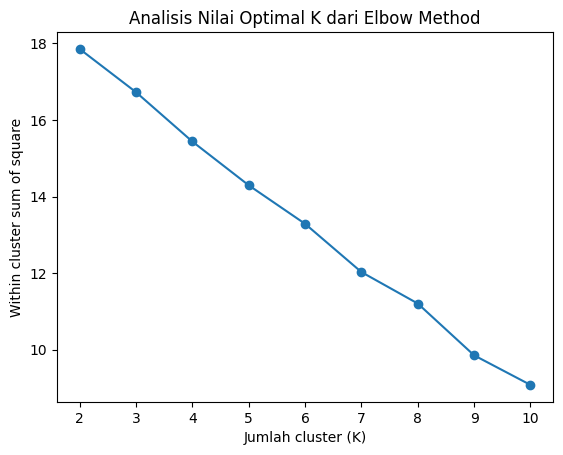

In [114]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

max_clusters = 10
wcss = []

for i in range(2, max_clusters + 1):
  # Proses K-means berulang-ulang sampai jumlah kluster tertentu
  kmeans = KMeans(n_clusters = i, random_state = 66)
  # Prediksi kluster tiap kalimat pada dokumen
  kmeans.fit_predict(tfs)
  # Tambahkan WCSS untuk jumlah K saat ini
  wcss.append(kmeans.inertia_)

# Tampilkan plot analisis skor silhouette
plt.plot([ i for i in range(2, max_clusters + 1) ], wcss, 'o-')
plt.xlabel('Jumlah cluster (K)') 
plt.ylabel('Within cluster sum of square') 
plt.title('Analisis Nilai Optimal K dari Elbow Method')
plt.show()

In [115]:
from kneed import KneeLocator
import warnings

# Tampilkan nilai WCSS
for i, s in enumerate(wcss):
  print(f'Nilai WCSS K = {i+2}: {s}')

# Hilangkan warning bila tidak terdapat siku/lutut
warnings.filterwarnings("ignore")

# Dapatkan indeks kluster yang terletak di siku/lutut
knee_cluster_index = KneeLocator(
  range(2, max_clusters + 1), wcss,
  curve = 'convex', direction = 'decreasing'
).knee

# Jika tidak ditemukan siku/lutut
if knee_cluster_index == None:
  print('Siku/lutut tidak ditemukan! Set ke K = 2...')
  knee_cluster_index = 2

print(f'Siku/lutut terletak pada K = {knee_cluster_index}')

Nilai WCSS K = 2: 17.856797182010965
Nilai WCSS K = 3: 16.72838251363765
Nilai WCSS K = 4: 15.438447408342267
Nilai WCSS K = 5: 14.295711335927091
Nilai WCSS K = 6: 13.28889944412948
Nilai WCSS K = 7: 12.028176475215542
Nilai WCSS K = 8: 11.205737271347372
Nilai WCSS K = 9: 9.852489216706005
Nilai WCSS K = 10: 9.079538063993203
Siku/lutut tidak ditemukan! Set ke K = 2...
Siku/lutut terletak pada K = 2


In [116]:
# Jalankan kembali K-means dengan nilai K terbaik
kmeans = KMeans(knee_cluster_index, random_state = 66)
kmeans.fit_predict(tfs)

# Simpan atribut penting untuk kluster terbaik
elbow_cluster_label = kmeans.labels_
elbow_cluster_center = kmeans.cluster_centers_

### 3.2.2. Silhouette Coefficient

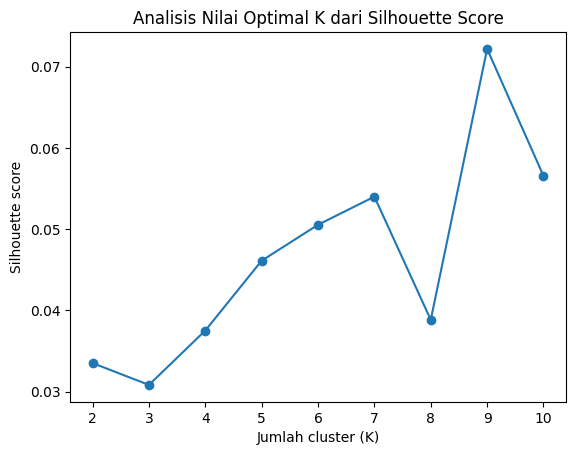

In [117]:
from sklearn.metrics import silhouette_score

max_clusters = 10
silhouette_avg = []

for i in range(2, max_clusters + 1):
  # Proses K-means berulang-ulang sampai jumlah kluster tertentu
  kmeans = KMeans(n_clusters = i, random_state = 66)
  # Prediksi kluster tiap kalimat pada dokumen
  kmeans.fit_predict(tfs)
  # Hitung skor silhoutte untuk jumlah K saat ini
  silhouette_avg.append(
    silhouette_score(tfs, kmeans.labels_, metric = 'euclidean')
  )
  # Jika skor tertinggi, simpan beberapa atribut untuk digunakan nanti
  if silhouette_avg[-1] == max(silhouette_avg):
    silhouette_cluster_label = kmeans.labels_
    silhouette_cluster_center = kmeans.cluster_centers_

# Tampilkan plot analisis skor silhouette
plt.plot([ i for i in range(2, max_clusters + 1) ], silhouette_avg, 'o-')
plt.xlabel('Jumlah cluster (K)') 
plt.ylabel('Silhouette score') 
plt.title('Analisis Nilai Optimal K dari Silhouette Score')
plt.show()

In [118]:
# Tampilkan nilai skor silhouette
for i, s in enumerate(silhouette_avg):
  print(f'Skor silhouette K = {i+2}: {s}')

print(f'Skor terbaik terletak pada K = {silhouette_avg.index(max(silhouette_avg))+2}')

Skor silhouette K = 2: 0.03350444933176658
Skor silhouette K = 3: 0.030818618195379708
Skor silhouette K = 4: 0.03751348238176114
Skor silhouette K = 5: 0.04611066801902721
Skor silhouette K = 6: 0.050535538171103636
Skor silhouette K = 7: 0.053993842720906245
Skor silhouette K = 8: 0.0388310322750225
Skor silhouette K = 9: 0.07218008795797888
Skor silhouette K = 10: 0.056548909693552245
Skor terbaik terletak pada K = 9


### 3.2.3. Silhouette Coefficient or Elbow Method?

In [119]:
# Jika memilih silhouette coefficient
# cluster_label = silhouette_cluster_label
# cluster_center = silhouette_cluster_center

# Jika memilih elbow method
cluster_label = elbow_cluster_label
cluster_center = elbow_cluster_center

# Tampilkan kluster tiap kalimat
for label in set(cluster_label):
  print(f'[Kluster {label}]')
  for i, sentence in enumerate(sentence_list):
    if cluster_label[i] == label:
      print(f'[{i+1}] {sentence}')
  print()

# print(cluster_label)

[Kluster 0]
[2] Aksi pilot mogok itu sudah berlangsung dua hari.
[5] Mereka tidak memberikan keterangan berapa lama mogok kerja itu berlangsung.
[7] Kenya Airways menghubungkan banyak negara ke Eropa dan Asia, sehingga aksi mogok pilot itu benar-benar melumpuhkan denyut penerbangan di negara tersebut.
[8] KALPA menyebut akan melakukan aksi mogok kerja menyusul sengketa kontribusi uang pensiun dan penyelesaian pembayaran gaji saat pandemi.
[9] Aksi mogok kerja itu dilakukan setelah tuntutan disampaikan 14 hari lalu tetapi manajemen Kenya Airways tidak meresponsnya.
[10] Manajemen Kenya Airways menggambarkan aksi mogok kerja oleh pilot tersebut melanggar hukum.
[11] Maskapai juga mengingatkan aksi itu bisa membahayakan upaya pemulihan dari pandemi Covid-19 karena bisa membuat Kenya Airways mengalami kerugian hingga Rp 39 miliar per hari.
[12] Direktur pelaksana dan CEO Kenya Airways, Allan Kilavuka, mendesak para pilot yang mogok, yang merupakan 10 persen dari karyawan maskapai, untuk ke

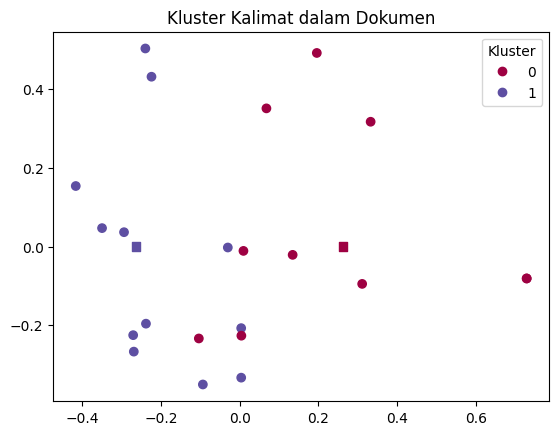

In [120]:
from sklearn.decomposition import PCA

# Gabungkan kolom frekuensi TF-IDF menjadi 2 dimensi saja
pca_tfs = PCA(n_components = 2).fit_transform(tfs.toarray())

# Gabungkan centroid kluster menjadi 2 dimensi saja
pca_cc = PCA(n_components = 2).fit_transform(cluster_center)

""" # Berikan warna secara dinamis untuk tiap kluster
colors = plt.cm.Spectral(np.linspace(0 , 1, len(set(cluster_label))))

# Tampilkan nomor kalimat dan warna kluster
for i in range(len(pca)):
  plt.plot(pca_tfs[i,0], pca_tfs[i,1], # marker = 'o',
      linestyle = '', c = colors[cluster_label[i]],
      markersize = 14, marker = f'${i+1}$'
  ) """

# Buat figur baru untuk visualisasi
fig, ax = plt.subplots()

# Tampilkan kalimat (tanpa penomoran) dan warna kluster
sc = ax.scatter(pca_tfs[:,0], pca_tfs[:,1], c = cluster_label, cmap = 'Spectral')
ax.legend(*sc.legend_elements(), title ='Kluster')

# Tampilkan centroid tiap kluster (kurang akurat karena pengurangan dimensi)
ax.scatter(pca_cc[:,0], pca_cc[:,1], marker = 's', label = 'Centroid',
  c = [ i for i in range(len(cluster_center)) ], cmap = 'Spectral'
)

# Tampilkan hasil visualisasi
plt.title("Kluster Kalimat dalam Dokumen")
plt.show()

In [121]:
# Dapatkan nilai rata-rata TF-IDF per kata dalam suatu kalimat
# Lalu, anggap nilai tersebut sebagai nilai TF-IDF kalimat
# Nilai nol pada list/array akan dihilangkan sebelum dirata-rata
sentence_relevancy = [ sum(t) / len(t) for t in tfs.toarray() ]

for i, r in enumerate(sentence_relevancy):
  print(f'Nilai TF-IDF (relevansi) S{i+1}: {r}')

Nilai TF-IDF (relevansi) S1: 0.027478208820388234
Nilai TF-IDF (relevansi) S2: 0.014116093204989692
Nilai TF-IDF (relevansi) S3: 0.027710610290763053
Nilai TF-IDF (relevansi) S4: 0.011519949866765833
Nilai TF-IDF (relevansi) S5: 0.013445925584948563
Nilai TF-IDF (relevansi) S6: 0.02530788569248461
Nilai TF-IDF (relevansi) S7: 0.026881652042650982
Nilai TF-IDF (relevansi) S8: 0.02995663756904592
Nilai TF-IDF (relevansi) S9: 0.02229126921292893
Nilai TF-IDF (relevansi) S10: 0.024803341032416083
Nilai TF-IDF (relevansi) S11: 0.029998971183572514
Nilai TF-IDF (relevansi) S12: 0.02974794731996856
Nilai TF-IDF (relevansi) S13: 0.019773046948722773
Nilai TF-IDF (relevansi) S14: 0.014116093204989692
Nilai TF-IDF (relevansi) S15: 0.02640061595837452
Nilai TF-IDF (relevansi) S16: 0.028893728192592446
Nilai TF-IDF (relevansi) S17: 0.025768312396187633
Nilai TF-IDF (relevansi) S18: 0.015605920056633638
Nilai TF-IDF (relevansi) S19: 0.026399311547167733
Nilai TF-IDF (relevansi) S20: 0.0346023607722

In [122]:
# Nilai TF-IDF mula-mula tiap kluster adalah nol
cluster_relevancy = [ 0 for _ in set(cluster_label) ]

for i, label in enumerate(set(cluster_label)):
  temp_cluster_members = 0
  for j, sentence in enumerate(sentence_list):
    if cluster_label[j] == label:
      # Totalkan nilai TF-IDF per kalimat menjadi nilai TF-IDF kluster
      cluster_relevancy[i] += sentence_relevancy[j]
      # Hitung jumlah kalimat dalam kluster yang sama
      temp_cluster_members += 1
  # Rata-ratakan nilai TF-IDF kluster (dibagi dengan jumlah kalimat)
  # Untuk mengurangi skew ke kluster dengan kalimat panjang
  cluster_relevancy[i] /= temp_cluster_members

for i, r in enumerate(cluster_relevancy):
  print(f'Nilai TF-IDF (relevansi) K{i}: {r}')

Nilai TF-IDF (relevansi) K0: 0.02209638504121445
Nilai TF-IDF (relevansi) K1: 0.02418117773030533


## 3.3. Text Summarization Result

In [123]:
# Simpan nomor kluster yang paling relevan
most_relevant_cluster = cluster_relevancy.index(max(cluster_relevancy))
# Simpan jumlah kalimat dari kluster yang paling relevan
top_cluster_members = 0

# Set jumlah kalimat maksimal untuk hasil ringkasan
max_summary_sentences = 5

# Teks gabungan hasil summarization
text_summarization_kmeans = ""
text_summarization_tfidf = ""

# Tampilkan kluster paling baik
print(f'[K-means clustering]')
for i, sentence in enumerate(sentence_list):
  if top_cluster_members == max_summary_sentences: break
  if cluster_label[i] == most_relevant_cluster:
    text_summarization_kmeans += sentence
    print(f'[{i+1}] {sentence}')
    top_cluster_members += 1

# ====================

# Dapatkan indeks dari kalimat dengan TF-IDF tertinggi
# Jumlah kalimat mengikuti kluster terbaik dari K-means
top_n_sentences = sorted(
  range(len(sentence_relevancy)),
  key = lambda i: sentence_relevancy[i],
  reverse = True
)[:top_cluster_members]

# Bandingkan K-means dengan TF-IDF biasa
print(f'\n[TF-IDF biasa]')
for i, sentence in enumerate(sentence_list):
  if i in top_n_sentences:
    text_summarization_tfidf += sentence
    print(f'[{i+1}] {sentence}')

[K-means clustering]
[1] Ribuan penumpang pesawat gagal terbang akibat pemogokan oleh Asosiasi Pilot Maskapai Kenya (KALPA).
[3] KALPA memastikan tidak ada penerbangan Kenya Airways yang diterbangkan oleh anggotanya dari Bandara Internasional Jomo Kenyatta Nairobi mulai pukul 06.00 pagi (0300 GMT) dan seterusnya.
[4] Pernyataan itu disampaikan pada Sabtu (5/11/2022) waktu setempat.
[6] Maskapai, yang dibangun bersama oleh pemerintah Kenya dan Air France-KLM itu, merupakan salah satu maskapai terbesar di Afrika.
[13] "Jika tidak dilaksanakan, pilot dianggap melakukan tindakan indisipliner," ia memperingatkan.

[TF-IDF biasa]
[8] KALPA menyebut akan melakukan aksi mogok kerja menyusul sengketa kontribusi uang pensiun dan penyelesaian pembayaran gaji saat pandemi.
[11] Maskapai juga mengingatkan aksi itu bisa membahayakan upaya pemulihan dari pandemi Covid-19 karena bisa membuat Kenya Airways mengalami kerugian hingga Rp 39 miliar per hari.
[12] Direktur pelaksana dan CEO Kenya Airways, A

In [124]:
print(f'Jumlah karakter teks awal: {len(doc)}')
print(f'Jumlah karakter teks K-means: {len(text_summarization_kmeans)}')
print(f'Jumlah karakter teks TF-IDF biasa: {len(text_summarization_tfidf)}')

# Tampilkan persentase pengurangan teks rangkuman dibanding teks asli
kmeans_char_diff = 100 - (len(text_summarization_kmeans) / len(doc) * 100)
print(f'Pengurangan teks pada K-means: {round(kmeans_char_diff)}%')
tfidf_char_diff = 100 - (len(text_summarization_tfidf) / len(doc) * 100)
print(f'Pengurangan teks pada TF-IDF biasa: {round(tfidf_char_diff)}%')

Jumlah karakter teks awal: 2661
Jumlah karakter teks K-means: 569
Jumlah karakter teks TF-IDF biasa: 896
Pengurangan teks pada K-means: 79%
Pengurangan teks pada TF-IDF biasa: 66%


# 4. Evaluation

## 4.1 Get Human-like Summary

In [149]:
import requests
import translators

def get_humanlike_summary(text, to_en_before = True, to_id_after = True):
  if to_en_before:
    # Translasi teks ke bahasa Inggris terlebih dahulu
    text = translators.google(text, from_language = 'id', to_language = 'en')

  # Registrasi API: https://rapidapi.com/ayfie-ayfie-default/api/summarizer10
  url = 'https://summarizer10.p.rapidapi.com/api/summarize'
  payload = { 'language': 'en', 'text': text, 'min_length': 100, 'max_length': 500 }
  headers = {
    'content-type': 'application/json',
    'X-RapidAPI-Key': 'fffd878241msh893a28cedac6994p1050f4jsn92d989f73435',
    'X-RapidAPI-Host': 'summarizer10.p.rapidapi.com'
  }

  # Dapatkan respons teks atau kosongkan bila error
  response = requests.request('POST', url, json = payload, headers = headers)
  text = response.json().get('result') or ''

  if not text:
    print('Terjadi error saat menerima respons dari API')
  elif text and to_id_after:
    print(f'[Sebelum translasi hasil]\n{text}\n\n[Sesudah translasi hasil]')
    # Translasi teks ke bahasa Indonesia kembali
    text = translators.google(text, from_language = 'en', to_language = 'id')
  
  return text

# Impor teks hasil rangkuman pembanding (rangkuman manusia lebih baik)
# text_summarization_human = get_text_auto('path_ke_file.txt')
text_summarization_human = get_humanlike_summary(doc)

# Tampilkan hasil rangkuman pembanding
print(text_summarization_human)

[Sebelum translasi hasil]
 Kenya Airline Pilots Association (KALPA) strike action has been going on for two days . No flights were flown by its members from Nairobi's Jomo Kenyatta International Airport from 06.00am (0300 GMT) onwards . The pilots demanded that the contributions be returned to the savings fund and the payment of all salaries to stop during the Covid-19 pandemic . Ground staff also went on strike on Saturday from 2pm due to a dispute with the Kenya Airport Authority .

[Sesudah translasi hasil]
Aksi mogok Kenya Airline Pilots Association (Kalpa) telah berlangsung selama dua hari. Tidak ada penerbangan yang diterbangkan oleh anggotanya dari Bandara Internasional Jomo Kenyatta Nairobi dari pukul 06.00 pagi (0300 GMT) dan seterusnya. Pilot menuntut agar kontribusi dikembalikan ke dana tabungan dan pembayaran semua gaji untuk berhenti selama pandemi Covid-19. Staf darat juga mogok pada hari Sabtu dari jam 2 siang karena perselisihan dengan Otoritas Bandara Kenya.


## 4.2. ROUGE Metrics

In [150]:
def rouge_preprocess(text_summarization):
  # Ubah semua teks menjadi huruf kecil
  text_summarization = text_summarization.lower()
  # Ubah semua tab dan baris baru menjadi spasi
  text_summarization = re.sub(r'\t|\n|\r', ' ', text_summarization)
  # Normalisasi karakter non-ASCII
  text_summarization = unicodedata.normalize('NFKC', text_summarization)

  # Pecah teks menjadi kalimat
  rouge_sentence_list = sentence_tokenization(text_summarization)

  for i, sentence in enumerate(rouge_sentence_list):
    # Hilangkan semua karakter non-alphanumerik
    sentence = re.sub(r'[^a-zA-Z\d\s]+', ' ', sentence)
    # Hilangkan whitespace beruntun (lebih dari satu)
    sentence = re.sub(r'\s\s+', ' ', sentence)
    # Tambahkan kembali titik sebagai pemisah kalimat
    sentence += "."
    # Simpan kalimat yang telah dimodifikasi
    rouge_sentence_list[i] = sentence
  
  # Gabung semua kalimat dan kembalikan
  return ' '.join(rouge_sentence_list)

# Lakukan preprocessing sebelum lanjut ke ROUGE
text_summarization_kmeans = rouge_preprocess(text_summarization_kmeans)
text_summarization_tfidf = rouge_preprocess(text_summarization_tfidf)
text_summarization_human = rouge_preprocess(text_summarization_human)

In [151]:
# https://github.com/pltrdy/rouge
from rouge import Rouge

def get_rouge_score(machine_summary, human_summary):
  # Hitung skor ROUGE antara teks rangkuman mesin dengan pembanding
  rouge = Rouge().get_scores(machine_summary, human_summary)[0]

  # Tampilkan hasilnya dalam bentuk recall, precision, dan skor F1
  for i, val in enumerate(rouge.values()):
    print(['ROUGE 1-gram','ROUGE 2-gram','ROUGE LCS'][i], end = ": ")
    print(f'{round(val["r"], 5)} (r), {round(val["p"], 5)} (p), {round(val["f"], 5)} (f)')

print('[Hasil ROUGE K-means]')
get_rouge_score(text_summarization_kmeans, text_summarization_human)

print('\n[Hasil ROUGE TF-IDF biasa]')
get_rouge_score(text_summarization_tfidf, text_summarization_human)

[Hasil ROUGE K-means]
ROUGE 1-gram: 0.42623 (r), 0.39394 (p), 0.40945 (f)
ROUGE 2-gram: 0.26471 (r), 0.23377 (p), 0.24828 (f)
ROUGE LCS: 0.39344 (r), 0.36364 (p), 0.37795 (f)

[Hasil ROUGE TF-IDF biasa]
ROUGE 1-gram: 0.4918 (r), 0.28302 (p), 0.35928 (f)
ROUGE 2-gram: 0.11765 (r), 0.06299 (p), 0.08205 (f)
ROUGE LCS: 0.36066 (r), 0.20755 (p), 0.26347 (f)
